02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [6]:
import warnings
import time
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [7]:
# データの読み込み
train = pd.read_csv('../data/processed/processed20240614_train.csv')

# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [19]:
# lightgbmのパラメータ
param = {'num_leaves': 50, #111
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

グリッドサーチの話

In [1]:
from sklearn.model_selection import GridSearchCV

In [24]:
# グリッドサーチ　
# lightgbmのパラメータ
param_grid = {'num_leaves': [30,50,80,111],
         'min_data_in_leaf': [149], 
         'objective':['regression'],
         'max_depth': [7,9,12,20],
         'learning_rate': [0.005],
         "boosting": ["gbdt"],
         "feature_fraction": [0.7522],
         "bagging_freq": [1],
         "bagging_fraction": [0.7083] ,
         "bagging_seed": [11],
         "metric": ['rmse'],
         "lambda_l1": [0.2634],
         "random_state": [133],
         "verbosity": [-1]}

In [4]:
from sklearn.metrics import make_scorer, mean_squared_error

# 評価指標の設定（平均二乗誤差の負の値）
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [15]:
del train['card_id']
del train['first_active_month']

In [25]:
from sklearn.model_selection import GridSearchCV

# LightGBMモデルの初期化
model = lgb.LGBMRegressor()

# グリッドサーチの設定
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, verbose=2)

# グリッドサーチの実行
grid_search.fit(train, target)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END bagging_fraction=0.7083, bagging_freq=1, bagging_seed=11, boosting=gbdt, feature_fraction=0.7522, lambda_l1=0.2634, learning_rate=0.005, max_depth=7, metric=rmse, min_data_in_leaf=149, num_leaves=30, objective=regression, random_state=133, verbosity=-1; total time=   2.0s
[CV] END bagging_fraction=0.7083, bagging_freq=1, bagging_seed=11, boosting=gbdt, feature_fraction=0.7522, lambda_l1=0.2634, learning_rate=0.005, max_depth=7, metric=rmse, min_data_in_leaf=149, num_leaves=30, objective=regression, random_state=133, verbosity=-1; total time=   2.2s
[CV] END bagging_fraction=0.7083, bagging_freq=1, bagging_seed=11, boosting=gbdt, feature_fraction=0.7522, lambda_l1=0.2634, learning_rate=0.005, max_depth=7, metric=rmse, min_data_in_leaf=149, num_leaves=30, objective=regression, random_state=133, verbosity=-1; total time=   4.7s
[CV] END bagging_fraction=0.7083, bagging_freq=1, bagging_seed=11, boosting=gbdt, feature_fra

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'bagging_fraction': [0.7083], 'bagging_freq': [1],
                         'bagging_seed': [11], 'boosting': ['gbdt'],
                         'feature_fraction': [0.7522], 'lambda_l1': [0.2634],
                         'learning_rate': [0.005], 'max_depth': [7, 9, 12, 20],
                         'metric': ['rmse'], 'min_data_in_leaf': [149],
                         'num_leaves': [30, 50, 80, 111],
                         'objective': ['regression'], 'random_state': [133],
                         'verbosity': [-1]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=2)

グリッドサーチ終わり

In [20]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [21]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
#predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(params=param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)])

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    with open(f'../src/models/model4_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.78257
[200]	valid_0's rmse: 3.73637
[300]	valid_0's rmse: 3.71189
[400]	valid_0's rmse: 3.69867
[500]	valid_0's rmse: 3.69095
[600]	valid_0's rmse: 3.68561
[700]	valid_0's rmse: 3.68207
[800]	valid_0's rmse: 3.67962
[900]	valid_0's rmse: 3.67767
[1000]	valid_0's rmse: 3.67611
[1100]	valid_0's rmse: 3.67514
[1200]	valid_0's rmse: 3.67431
[1300]	valid_0's rmse: 3.67353
[1400]	valid_0's rmse: 3.67309
[1500]	valid_0's rmse: 3.67274
[1600]	valid_0's rmse: 3.67222
[1700]	valid_0's rmse: 3.67198
[1800]	valid_0's rmse: 3.67179
[1900]	valid_0's rmse: 3.67189
Early stopping, best iteration is:
[1777]	valid_0's rmse: 3.67163
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.71109
[200]	valid_0's rmse: 3.66879
[300]	valid_0's rmse: 3.64773
[400]	valid_0's rmse: 3.63701
[500]	valid_0's rmse: 3.6305
[600]	valid_0's rmse: 3.62655
[700]	valid_0's rmse: 3.62372
[80

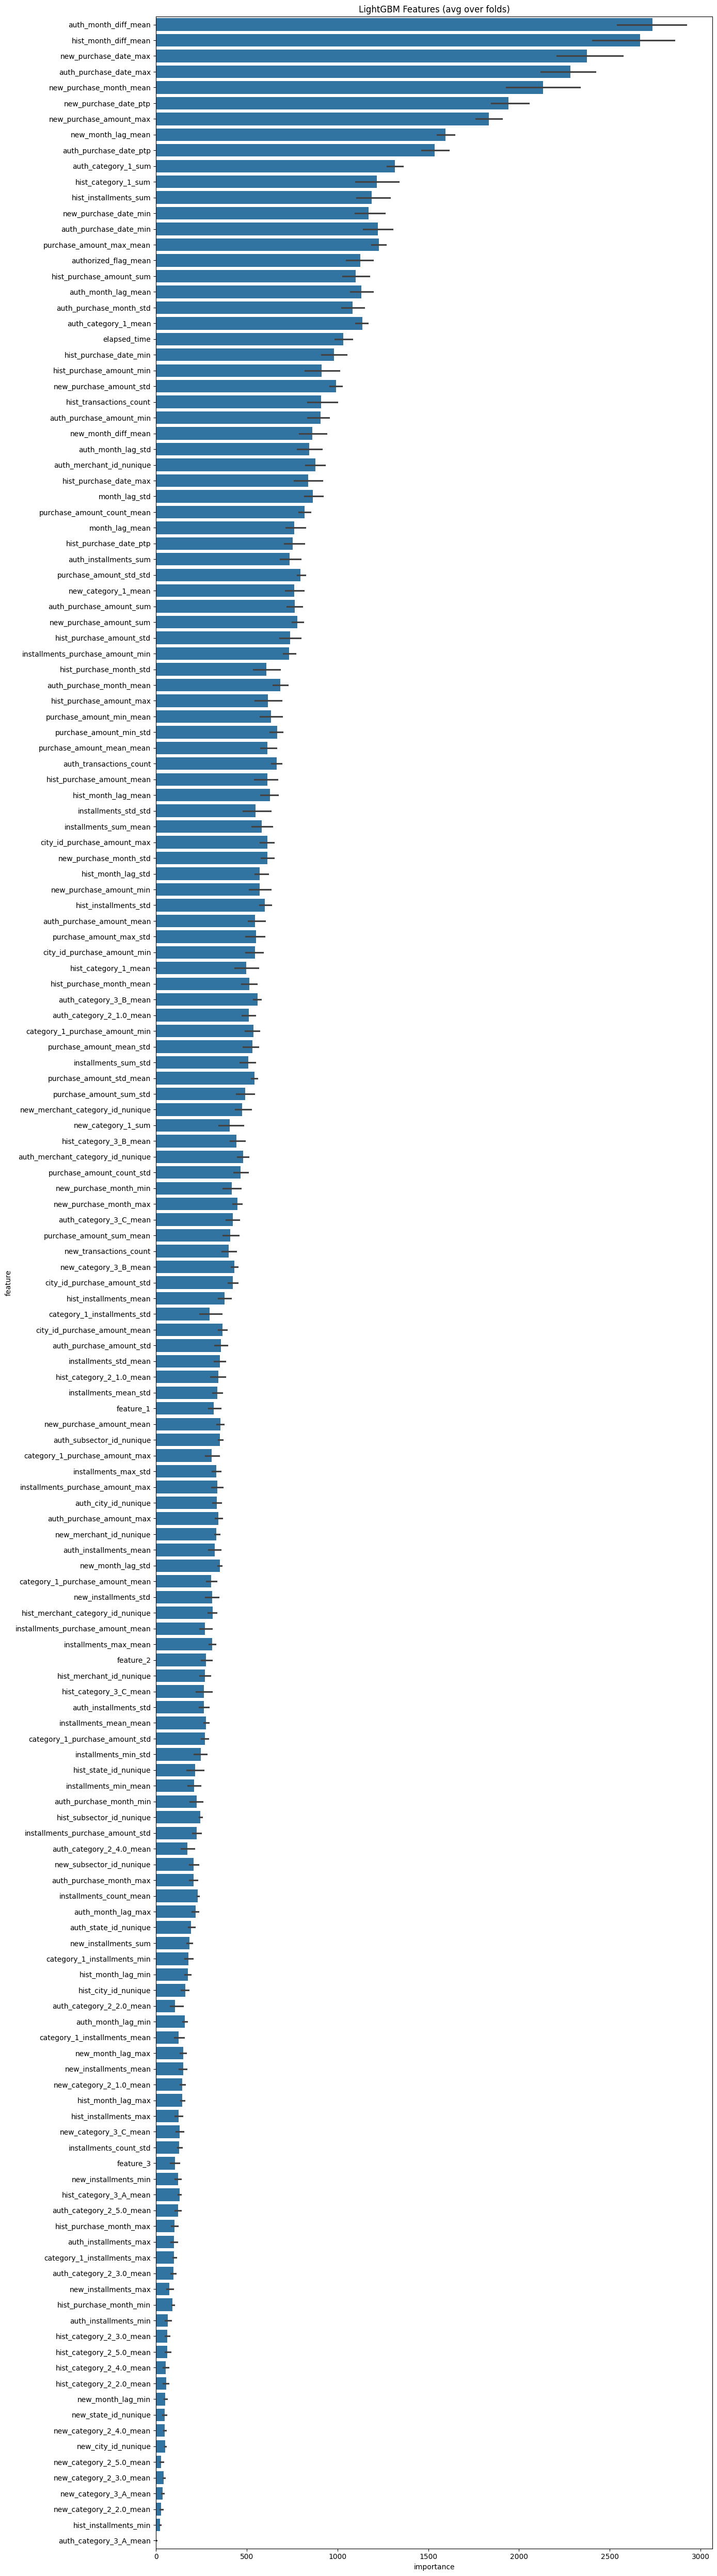

In [22]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')